In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
import warnings
import itertools

%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\Project\dataset\dengue08.csv')
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,cases
0,2008-01-01,0
1,2008-02-01,0
2,2008-03-01,0
3,2008-04-01,0
4,2008-05-01,0


In [3]:
df.set_index('date', inplace=True)

<Axes: xlabel='date', ylabel='cases'>

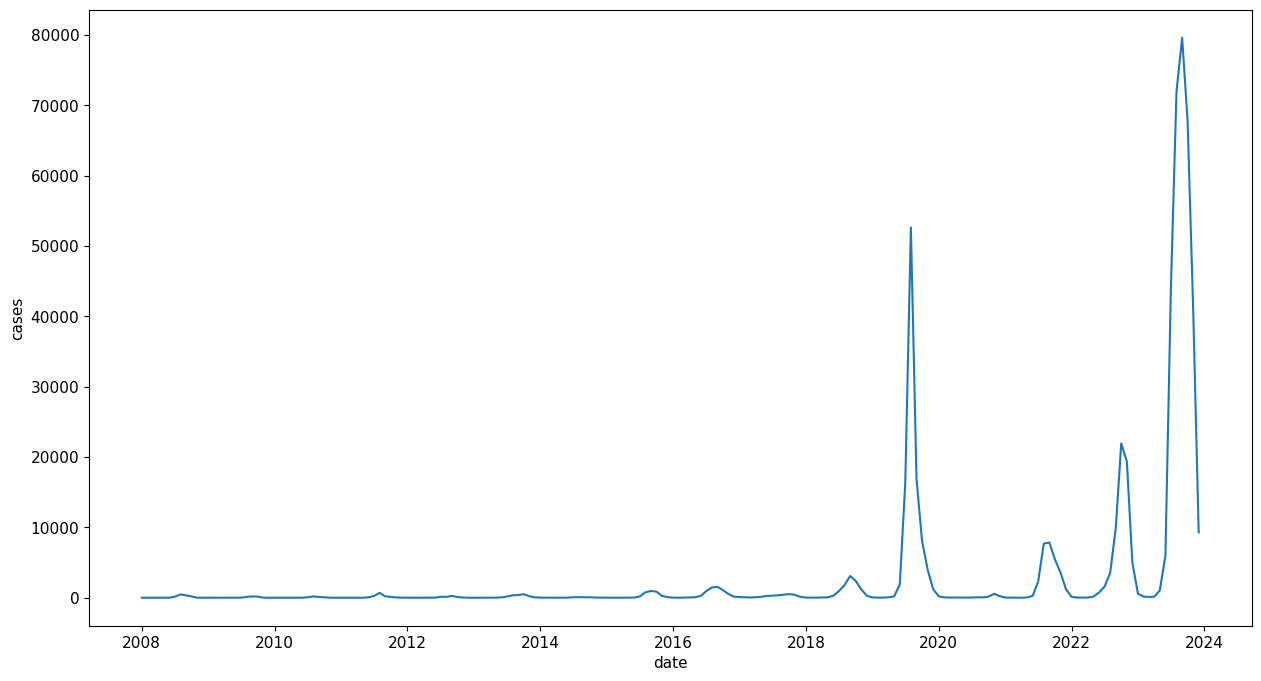

In [4]:
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(15, 8))
sns.lineplot(data=df, x=df.index, y=df.cases)

### Grid Search for the best parameters of SARIMA

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import sys

# Set the frequency of the DateTime index
df.index.freq = 'MS'

# Define non-seasonal p, d, q combinations
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Define seasonal p, d, q combinations with a smaller range
seasonal_p = seasonal_d = seasonal_q = range(0, 2)  # Limiting seasonal parameters to 0 and 1
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(seasonal_p, seasonal_d, seasonal_q)]

# Store AIC, and parameter combinations
aic_results = []

# Number of iterations for progress tracking
total_iterations = len(pdq) * len(seasonal_pdq)
current_iteration = 0

# Iterate through SARIMA models
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(df['cases'],
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            aic_results.append((param, param_seasonal, results.aic))
        except Exception as e:
            continue  # Skip iteration on exception
        finally:
            current_iteration += 1
            print(f"Completed: {current_iteration}/{total_iterations}", end='\r')
            sys.stdout.flush()

# Sort results by AIC
aic_results.sort(key=lambda x: (x[2] if isinstance(x[2], float) else float('inf')))

# Display the top 5 models based on AIC
aic_results[:5]

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[((2, 1, 2), (0, 1, 1, 12), 3323.69647657735),
 ((2, 1, 2), (1, 1, 1, 12), 3324.5363208604776),
 ((2, 2, 2), (0, 1, 1, 12), 3329.2944424472744),
 ((2, 2, 2), (1, 1, 1, 12), 3330.848181633334),
 ((1, 1, 2), (0, 1, 1, 12), 3333.3450955888693)]

#### Sarimax from the lowest AIC

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMAX model
mod = SARIMAX(df['cases'], order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
results = mod.fit(disp=False)

# Display the model summary
print(results.summary())

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                       
Dep. Variable:                                cases   No. Observations:                  192
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1796.138
Date:                              Wed, 03 Jan 2024   AIC                           3604.277
Time:                                      14:51:17   BIC                           3623.401
Sample:                                  01-01-2008   HQIC                          3612.031
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7231      0.105     16.486      0.000       1.518       1.928
ar.L2         -0.99

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
print(f"AIC: {results.aic}")
print(f"BIC: {results.bic}")

AIC: 3604.276624725052
BIC: 3623.4009395600965


#### MAE & RMSE calculation

In [8]:
# Calculate the Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
in_sample_preds = results.get_prediction(start=pd.to_datetime('2008-01-01'),
                                         dynamic=False)
y_true = df['cases']
y_pred = in_sample_preds.predicted_mean
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# Calculate RMSE

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

MAE: 1572.0955557232946
RMSE: 5173.864466090654


#### Forecast

In [9]:
# Forecast for 2024
forecast = results.get_forecast(steps=12)
pred_conf = forecast.conf_int()

#### Plot for observation

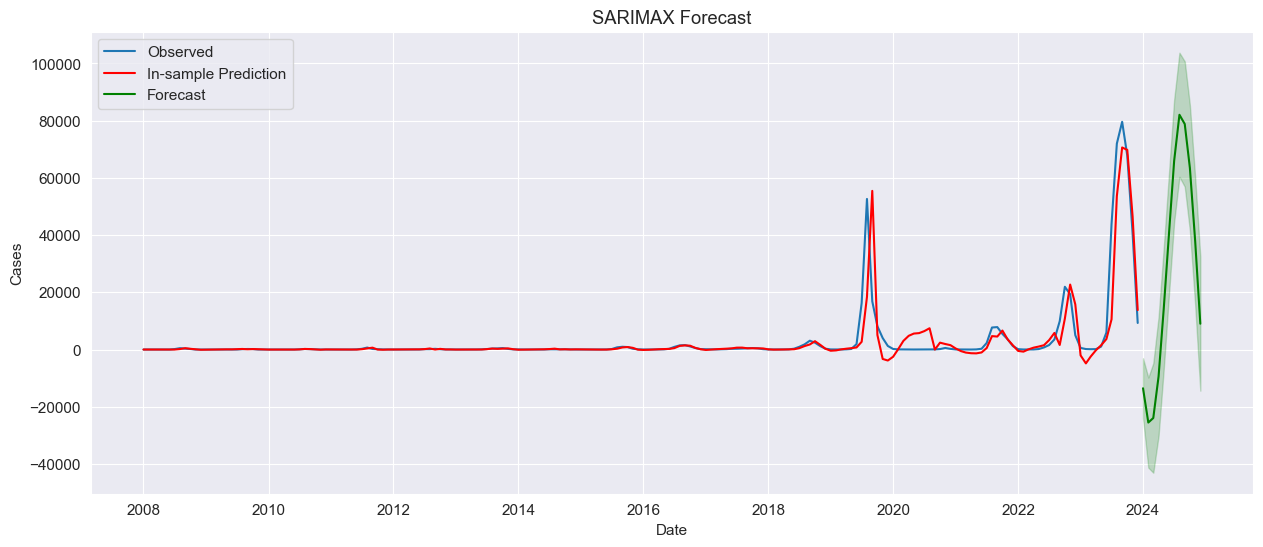

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['cases'], label='Observed')
plt.plot(y_pred.index, y_pred, label='In-sample Prediction', color='r')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='g')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='green', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('SARIMAX Forecast')
plt.legend(loc='upper left')

plt.savefig("005.sarima_grid_forecast.png", bbox_inches='tight')

plt.show()

In [11]:
# Extracting the forecasted values
forecasted_values = forecast.predicted_mean

# Printing the forecasted values
print(forecasted_values)

2024-01-01   -13536.612760
2024-02-01   -25515.542397
2024-03-01   -23938.777255
2024-04-01    -9401.786911
2024-05-01    14114.672252
2024-06-01    40579.841099
2024-07-01    65922.606604
2024-08-01    82055.237547
2024-09-01    78824.761528
2024-10-01    63497.547489
2024-11-01    37859.997452
2024-12-01     9027.906407
Freq: MS, Name: predicted_mean, dtype: float64


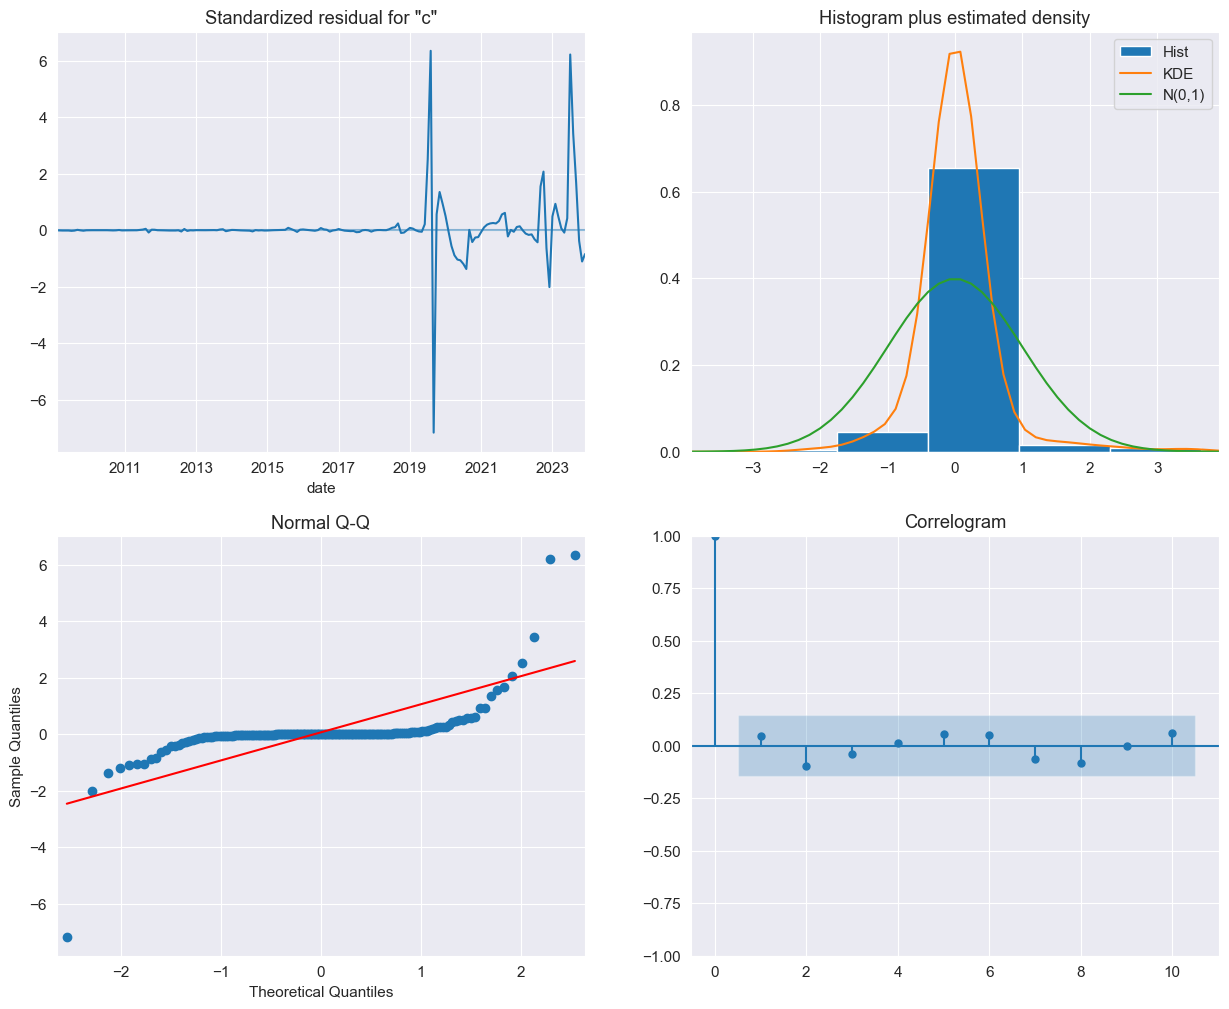

In [12]:
#Residual Analysis
results.plot_diagnostics(figsize=(15, 12))
plt.savefig("006.sarima_grid_residuals.png", bbox_inches='tight')

plt.show()


In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = results.resid

# Perform the Ljung-Box test
ljung_box_results = acorr_ljungbox(residuals, lags=10)

# Directly print the results
print("Ljung-Box test results:")
print(ljung_box_results)

Ljung-Box test results:
     lb_stat  lb_pvalue
1   0.357757   0.549755
2   2.264638   0.322285
3   2.559309   0.464668
4   2.602618   0.626359
5   3.191816   0.670441
6   3.733093   0.712743
7   4.481950   0.722890
8   5.879914   0.660681
9   5.879915   0.751874
10  6.648407   0.758168
